# DESCRIPCION

La idea es realizar un sistema de recomendaciones de peliculas para usuarios aplicando la técnica de filtrado colaborativo. Recomendar peliculas a un usuario especifico respecto a la preferencia de muchos otros usuarios similares.

El modelo a entrenar sera una red neuronal multicapa, por cada entrada se tendra una capa de embedding para usuarios y peliculas del dataset, se encontraran similitudes entre usuarios  a travez del producto punto etre un vector que contendra las entradas de usuarios y las peliculas para obtener las puntuaciones de coincidencias (el rating de la película).

Dataset: https://www.kaggle.com/c/movielens-100k

El dataset utilizado será el conjunto de datos movielens mas pequeño con fines educativos, pero la idea se extiende a dataset mas grandes, en este proyecto se utilizó por falta de recursos computacionales.

In [94]:
#IMPORTAR LIBRERIAS NECESARIAS
#=======================================================================#

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization, Add, Dot, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, he_normal,he_uniform
from keras.callbacks import CSVLogger,ModelCheckpoint,EarlyStopping
from keras.optimizers import Adam
from keras import layers
import math

In [364]:
#CARGAR DATASET
#=============================================================================#
movies = pd.read_csv('data/movies.csv')
#tags = pd.read_csv('data/tags.csv')
ratings = pd.read_csv('data/ratings.csv')

In [365]:
#ELIMINAR VALORES NULOS
#====================================================================#
movies = movies.dropna()
#tags = users.dropna()

print(ratings.shape)
ratings = ratings.dropna()

(100836, 4)


In [124]:
#OBTENER PELICULAS QUE SE ENCUENTRAN DENTRO DEL DATASET RAITINGS
#=====================================================================================#
def getSubsetMvovies(first_list, second_list):
    unique_movies = []
    for f in first_list:
        if f in second_list:
            unique_movies.append(f)
    return unique_movies

In [126]:
#PELICULAS UNICAS
#======================================================================================#
first_list = list(ratings['movieId'].unique())
second_list = list(movies['movieId'])

unique_movies = getSubsetMvovies(first_list,second_list)
len(unique_movies)

9724

In [128]:
df_unique_movies = ratings.loc[ratings['movieId'].isin(unique_movies)]
df_unique_movies.shape

(100836, 4)

In [129]:
#DATASET CON COLUMNAS A UTILIZAR
#===============================================================================#
df = df_unique_movies[['userId','movieId','rating']]

In [131]:
print(movies.shape)
print(users.shape)

(9742, 3)
(3683, 4)


In [132]:
df.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


Se observa que la media del rating se encuentra aproximadamente en 3, con una desviacion estandar de 1.04, existen ratings calficados como 0 y calificados como 5, calificaciones de 1 a 5

In [137]:
#DICCIONARIO DE PELICULAS E INDICES
#=============================================================================================#
dict_movies = {}
movies_array = np.array(movies)
for i in range(movies.shape[0]):
    dict_movies[movies_array[i][0]] = {'title':movies_array[i][1],'genres':movies_array[2]}

In [139]:
#DISTRIBUCIÓN DE RATINGS
#============================================================================================#
counts_values = df['rating'].value_counts(normalize=True)
counts_values

4.0    0.265957
3.0    0.198808
5.0    0.131015
3.5    0.130271
4.5    0.084801
2.0    0.074884
2.5    0.055040
1.0    0.027877
1.5    0.017762
0.5    0.013586
Name: rating, dtype: float64

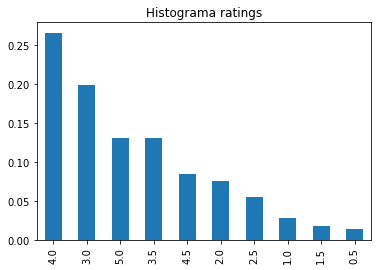

In [140]:
#GRAFICA DE BARRAS PARA RATINGS
#=================================================================================================#
plt.title('Histograma ratings')
counts_values.plot.bar()
plt.show()

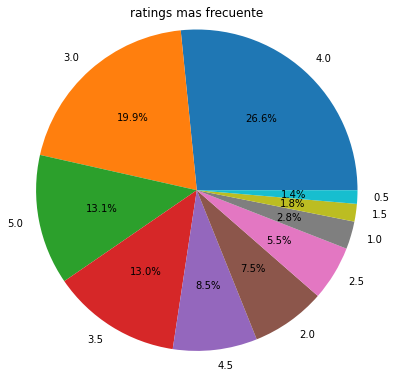

In [141]:
#GRAFICA PIE
#============================================================================#
plt.figure(figsize=(6,8))
plt.title("ratings mas frecuente")
my_pie,_,_ = plt.pie(list(counts_values),radius = 1.2,autopct="%.1f%%", labels=counts_values.index)
plt.show()

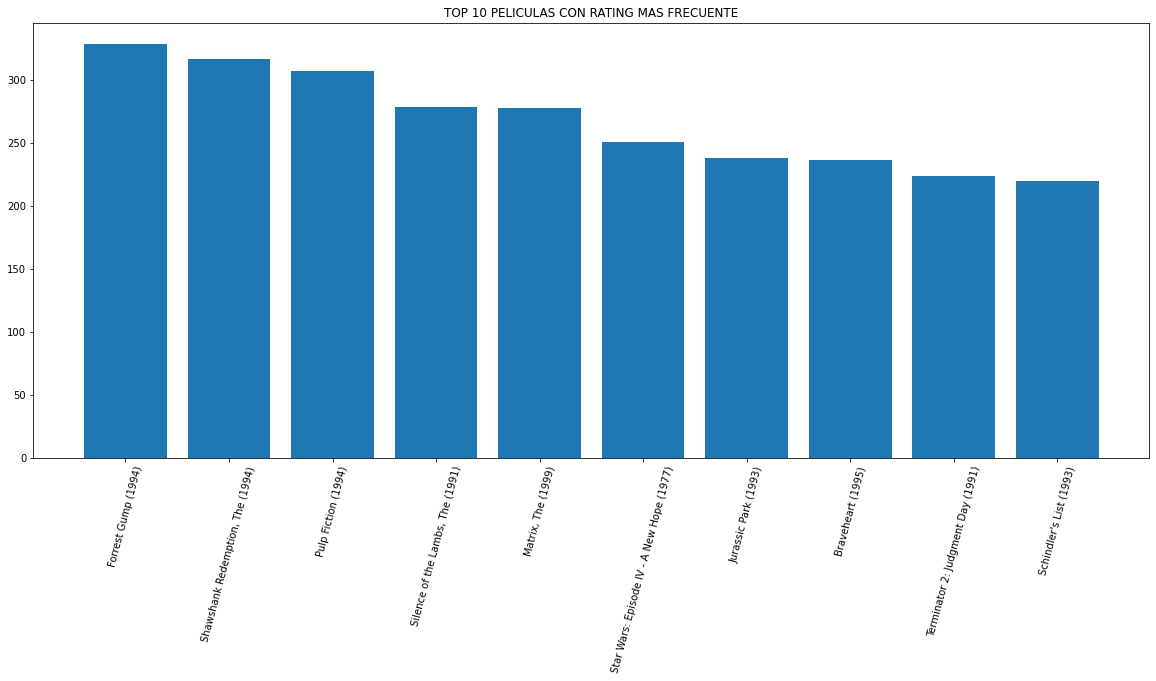

In [144]:
#TOP 10 DE PELICULAS CON RATINGS MAS FRECUENTE
#=================================================================================#
grouped_m_r = df[['movieId','rating']].groupby(['movieId']).count().reset_index()
top_10 = grouped_m_r.sort_values(['rating'], ascending=False).head(10)

titles = list(top_10['movieId'])

names_m = []
for i in top_10['movieId']:
    names_m.append(dict_movies[i]['title'])

top_10['title'] = names_m

plt.figure(figsize=(20,8))
plt.title("TOP 10 PELICULAS CON RATING MAS FRECUENTE")
plt.bar(list(top_10['title']),list(top_10['rating']))
plt.xticks(rotation=75)
plt.show()

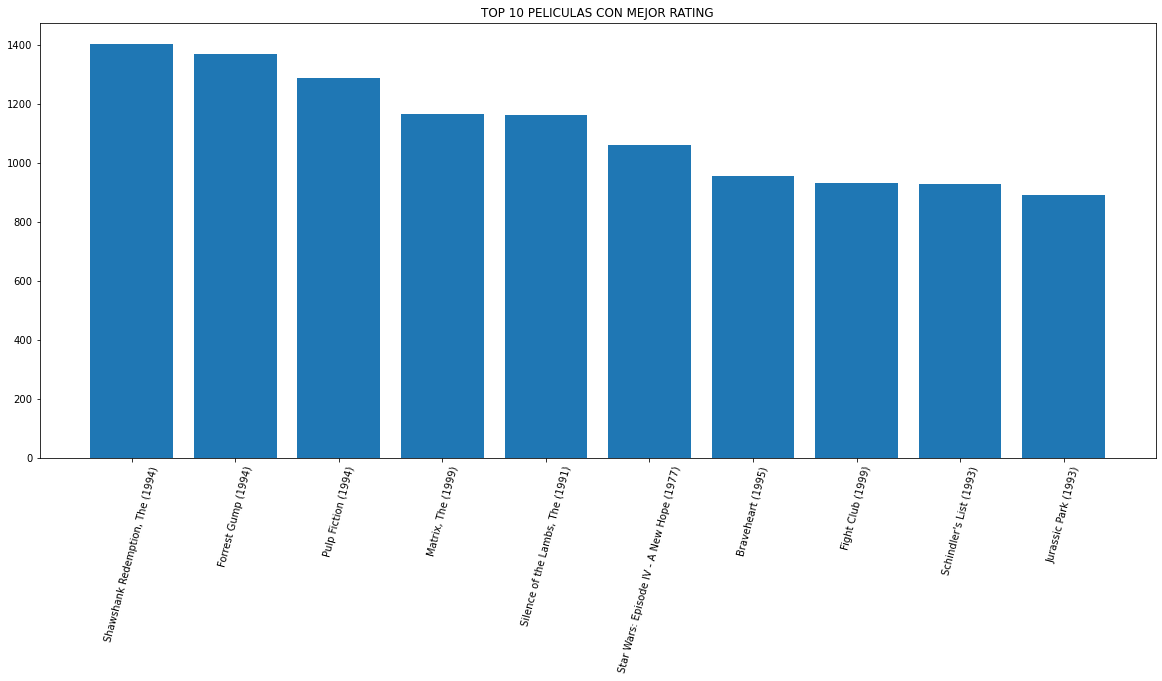

In [146]:
#PELICULAS CON EL RATINGS MAS ALTO
#=====================================================================================#

grouped_m_r = df[['movieId','rating']].groupby(['movieId']).sum().reset_index()
top_10 = grouped_m_r.sort_values(['rating'], ascending=False).head(10)

titles = list(top_10['movieId'])

names_m = []
for i in top_10['movieId']:
    names_m.append(dict_movies[i]['title'])

top_10['title'] = names_m

plt.figure(figsize=(20,8))
plt.title("TOP 10 PELICULAS CON MEJOR RATING")
plt.bar(list(top_10['title']),list(top_10['rating']))
plt.xticks(rotation=75)
plt.show()

In [147]:
#PREPROCESAMIENTO
#=========================================================================================#

user_ids = df["userId"].unique().tolist()
print("unique users",len(user_ids))
movie_ids = df["movieId"].unique().tolist()
print("unique movies",len(movie_ids))

user_encoded = {x: i for i, x in enumerate(user_ids)}
user_decoded = {i: x for i, x in enumerate(user_ids)}

movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_decoded = {i: x for i, x in enumerate(movie_ids)}

num_users = len(user_encoded)
num_movies = len(movie_encoded)

unique users 610
unique movies 9724


In [148]:
df["user"] = df["userId"].map(user_encoded)
df["movie"] = df["movieId"].map(movie_encoded)

In [149]:
df["rating"] = df["rating"].values.astype(np.float32)

min_rating = min(df["rating"])
max_rating = max(df["rating"])

In [191]:
X = df[["user","movie"]].values

#normalizamos los valores de rating
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [246]:
#DIVISIÓN DEL DATASET ENTRENAMIENTO Y TEST
#===========================================================================================#

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=10)

In [253]:
#CREANDO MODELO
#======================================================================================#

embedding_size = 50

#entradas para users y ratins
user_input = Input(shape=[1],name='Item_User')
movie_input = Input(shape=[1],name='Item_Movie')

#embedding usuario
user_embedding = Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
            name="user_embedding"
        )(user_input)

#agregar bias
user_bias = Embedding(num_users+1,1,name="user_bias")(user_input)

#agregar embedding para movies
movie_embedding = Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
            name="movie_embedding",
        )(movie_input)

#agregar bias para movies
movie_bias = Embedding(num_movies, 1,name="movie_bias")(movie_input)

#vector para la capa de user embedding
user_vec = Flatten(name='FlattenUsers')(user_embedding)

#vector para movie embedding
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

#proucto punto entre user y movies para encontrar las interacciones
prod = keras.layers.dot([movie_vec, user_vec], axes=1,name='DotProduct')

#añadimos el bias
add = Add(name="add")([prod,user_bias,movie_bias])

#salida sigmoidal para encontrar puntuaciones altas
ouput = Dense(1,activation="sigmoid",name="ouput")(add)

model = Model([user_input, movie_input], outputs=ouput)

In [254]:
#COMPILAR Y MOSTRAR MODELO
#===================================================================================#

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001))
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item_Movie (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Item_User (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 20)        194480      Item_Movie[0][0]                 
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        12200       Item_User[0][0]                  
___________________________________________________________________________________________

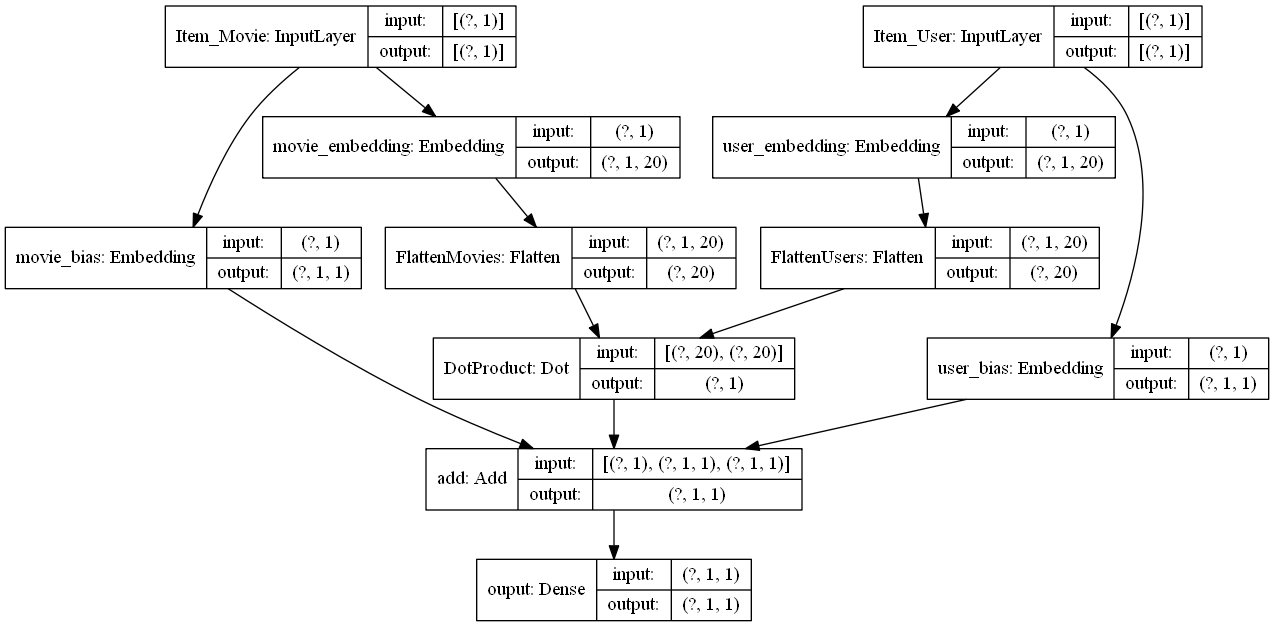

In [255]:
from keras.utils import plot_model
plot_model(model, to_file='model_descision.png', show_shapes=True, show_layer_names=True)

In [261]:
#DEFINIENDO CALLBACKS
filepath = 'checkpoints\cp-mlp_8{epoch:02d}.hdf5'

early_stop = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience=10)

#GUARDAR MODELO POR CADA ITERACION
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

#GUARDAR EL HISTORIAL DE APRENDIZAJE DEL MODELO
csv_logger = CSVLogger("checkpoints/model_history_sentiment_log8.csv", append=True)

In [257]:
#ENTRENAR MODELO
#==============================================================================#
df_train = pd.DataFrame(X_train,columns=['user','movie'])
df_test = pd.DataFrame(X_test,columns=['user','movie'])
history = model.fit(
    x=[df_train.user,df_train.movie],
    y=y_train,
    batch_size=32,
    epochs=20,
    verbose=1,
    validation_data=([df_test.user, df_test.movie], y_test),
    callbacks=[checkpoint,csv_logger,early_stop]
)

Epoch 1/20
2502/2521 [============================>.] - ETA: 0s - loss: 0.6735
Epoch 00001: loss improved from inf to 0.67336, saving model to checkpoints\cp-mlp_701.hdf5
2521/2521 [==============================] - 7s 3ms/step - loss: 0.6734 - val_loss: 0.6568
Epoch 2/20
2505/2521 [============================>.] - ETA: 0s - loss: 0.6438
Epoch 00002: loss improved from 0.67336 to 0.64379, saving model to checkpoints\cp-mlp_702.hdf5
2521/2521 [==============================] - 8s 3ms/step - loss: 0.6438 - val_loss: 0.6361
Epoch 3/20
2518/2521 [============================>.] - ETA: 0s - loss: 0.6278
Epoch 00003: loss improved from 0.64379 to 0.62786, saving model to checkpoints\cp-mlp_703.hdf5
2521/2521 [==============================] - 10s 4ms/step - loss: 0.6279 - val_loss: 0.6262
Epoch 4/20
2517/2521 [============================>.] - ETA: 0s - loss: 0.6188
Epoch 00004: loss improved from 0.62786 to 0.61883, saving model to checkpoints\cp-mlp_704.hdf5
2521/2521 [===================

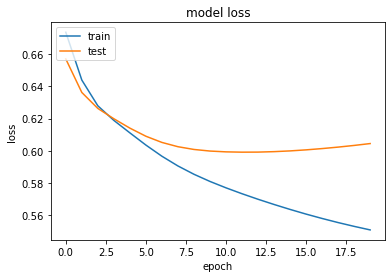

In [258]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

Observamos que el modelo converge con los datos de entrenamiento pero no converge muy bien con los datos devalidación.

In [307]:
#SEGUNDO MODELO
#========================================================================================#
n_latent_factors = 20

#definiento entrada, capa embedding y flatten para movies
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(num_movies + 1, n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
 
#definiendo entrada, capa embedding y flatten para usuarios 
user_input = keras.layers.Input(shape=[1],name='User')
movie_embedding = keras.layers.Embedding(num_users + 1, n_latent_factors,name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(movie_embedding)
 
#producto punto
prod = keras.layers.dot([movie_vec, user_vec], axes=1,name='DotProduct')

#salida sigmoidal
output = Dense(1,activation="sigmoid")(prod)

model = keras.Model([user_input, movie_input], output)


model.compile(optimizer=keras.optimizers.Adam(lr=0.00001), loss='mean_squared_error',  metrics=['mae', 'mse'])

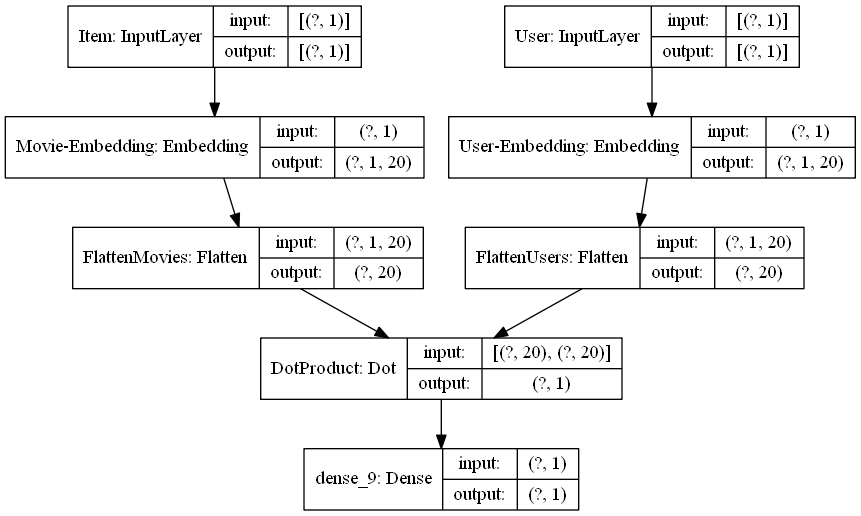

In [308]:
plot_model(model, to_file='model_descision.png', show_shapes=True, show_layer_names=True)

In [309]:
#ENTRENAMIENTO
#==================================================================================#
df_train = pd.DataFrame(X_train,columns=['user','movie'])
df_test = pd.DataFrame(X_test,columns=['user','movie'])
history2 = model.fit(
    x=[df_train.user,df_train.movie],
    y=y_train,
    batch_size=32,
    epochs=17,
    verbose=1,
    validation_data=([df_test.user, df_test.movie], y_test),
    callbacks=[checkpoint,csv_logger,early_stop]
)

Epoch 1/17
2503/2521 [============================>.] - ETA: 0s - loss: 0.0807 - mae: 0.2415 - mse: 0.0807
Epoch 00001: loss did not improve from 0.02544
2521/2521 [==============================] - 8s 3ms/step - loss: 0.0807 - mae: 0.2415 - mse: 0.0807 - val_loss: 0.0791 - val_mae: 0.2388 - val_mse: 0.0791
Epoch 2/17
2497/2521 [============================>.] - ETA: 0s - loss: 0.0787 - mae: 0.2378 - mse: 0.0787
Epoch 00002: loss did not improve from 0.02544
2521/2521 [==============================] - 7s 3ms/step - loss: 0.0787 - mae: 0.2377 - mse: 0.0787 - val_loss: 0.0772 - val_mae: 0.2351 - val_mse: 0.0772
Epoch 3/17
2499/2521 [============================>.] - ETA: 0s - loss: 0.0769 - mae: 0.2341 - mse: 0.0769
Epoch 00003: loss did not improve from 0.02544
2521/2521 [==============================] - 9s 3ms/step - loss: 0.0769 - mae: 0.2340 - mse: 0.0769 - val_loss: 0.0754 - val_mae: 0.2314 - val_mse: 0.0754
Epoch 4/17
2514/2521 [============================>.] - ETA: 0s - loss: 0

Se observa la mejora del modelo con una red mas simple, sin agregarle sesgo. el modelo converge en los datos de entrenamiento y validación.

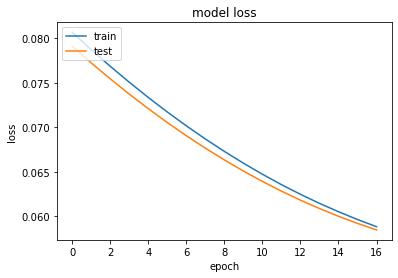

In [310]:
plt.plot(history2.history["loss"])
plt.plot(history2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [363]:
#GUARDANDO MEJOR MODELO
#========================================================#
model.save('best_model.hdf5')